In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Load the Pima Indians Diabetes dataset
df = pd.read_csv("diabetes.csv")

# Look at first 5 rows
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()
df.describe()
df["Outcome"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,count
Outcome,
0,500
1,268


In [4]:
X = df.drop("Outcome", axis=1).values  # shape: (n_samples, 8)
y = df["Outcome"].values.reshape(-1, 1)  # shape: (n_samples, 1)

# 2) Train–test split (80% train, 20% test, stratified by Outcome)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614, 1), (154, 1))

In [5]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [6]:
from sklearn.linear_model import LogisticRegression

# sklearn expects 1D labels for binary classification
y_train_flat = y_train.ravel()
y_test_flat  = y_test.ravel()

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train_flat)

y_pred_sklearn = log_reg.predict(X_test_scaled)

print("Sklearn Logistic Regression accuracy:", accuracy_score(y_test_flat, y_pred_sklearn))
print("Confusion matrix:\n", confusion_matrix(y_test_flat, y_pred_sklearn))


Sklearn Logistic Regression accuracy: 0.7142857142857143
Confusion matrix:
 [[82 18]
 [26 28]]


In [7]:
# Add bias term (column of ones) to X
m_train, n_features = X_train_scaled.shape

X_train_bias = np.hstack([np.ones((m_train, 1)), X_train_scaled])  # shape: (m_train, n_features + 1)
m_test = X_test_scaled.shape[0]
X_test_bias  = np.hstack([np.ones((m_test, 1)), X_test_scaled])

print("X_train_bias shape:", X_train_bias.shape)


X_train_bias shape: (614, 9)


In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def binary_cross_entropy(y_true, y_pred):
    """
    y_true: (m, 1)
    y_pred: (m, 1)
    """
    eps = 1e-15  # avoid log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    m = y_true.shape[0]
    loss = - (1 / m) * np.sum(
        y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
    )
    return loss


In [9]:
# Initialize weights (n_features + 1, 1) including bias
np.random.seed(42)
W = np.zeros((n_features + 1, 1))

learning_rate = 0.1
n_iterations = 2000

loss_history = []

for i in range(n_iterations):
    # 1) Linear combination: z = XW
    z = X_train_bias @ W                 # shape: (m_train, 1)

    # 2) Predicted probabilities via sigmoid
    y_pred = sigmoid(z)                  # shape: (m_train, 1)

    # 3) Compute loss (scalar)
    loss = binary_cross_entropy(y_train, y_pred)
    loss_history.append(loss)

    # 4) Gradient of loss w.r.t W
    # grad = (1/m) * X^T (y_pred - y)
    m = X_train_bias.shape[0]
    grad = (1 / m) * (X_train_bias.T @ (y_pred - y_train))  # shape: (n_features + 1, 1)

    # 5) Gradient descent update
    W = W - learning_rate * grad

    # Optional: print progress every 200 iterations
    if (i + 1) % 200 == 0:
        print(f"Iteration {i+1}/{n_iterations}, Loss = {loss:.4f}")


Iteration 200/2000, Loss = 0.4685
Iteration 400/2000, Loss = 0.4664
Iteration 600/2000, Loss = 0.4662
Iteration 800/2000, Loss = 0.4662
Iteration 1000/2000, Loss = 0.4662
Iteration 1200/2000, Loss = 0.4662
Iteration 1400/2000, Loss = 0.4662
Iteration 1600/2000, Loss = 0.4662
Iteration 1800/2000, Loss = 0.4662
Iteration 2000/2000, Loss = 0.4662


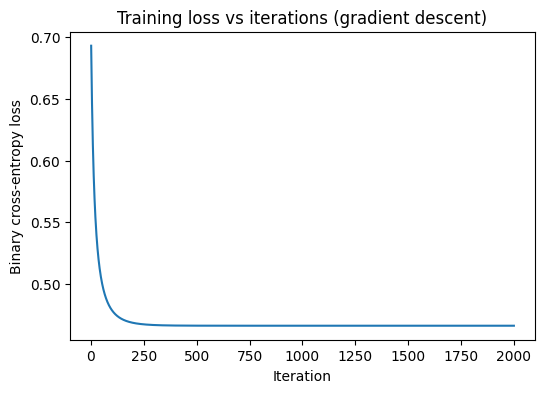

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, n_iterations + 1), loss_history)
plt.xlabel("Iteration")
plt.ylabel("Binary cross-entropy loss")
plt.title("Training loss vs iterations (gradient descent)")
plt.show()


In [11]:
# Predict probabilities on test set
z_test = X_test_bias @ W
y_test_pred_proba = sigmoid(z_test)

# Convert probabilities to class labels: 1 if p >= 0.5 else 0
y_test_pred = (y_test_pred_proba >= 0.5).astype(int)

print("First 10 predicted labels:", y_test_pred[:10].ravel())
print("First 10 true labels:", y_test_flat[:10])


First 10 predicted labels: [1 0 0 0 0 0 0 1 0 1]
First 10 true labels: [0 0 0 1 0 0 1 1 0 0]


In [12]:
# Accuracy
accuracy_custom = accuracy_score(y_test_flat, y_test_pred.ravel())
print("Custom logistic regression accuracy:", accuracy_custom)

# Confusion matrix
cm = confusion_matrix(y_test_flat, y_test_pred.ravel())
print("Confusion matrix:\n", cm)

print("\nClassification report:\n", classification_report(y_test_flat, y_test_pred.ravel()))


Custom logistic regression accuracy: 0.7142857142857143
Confusion matrix:
 [[82 18]
 [26 28]]

Classification report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154

